### Import Library

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
import cv2
import numpy as np

### Membuat kerangka data dari label path

In [2]:
# Definisi jalur direktori yang berisi gambar
sdir = r'C:\Users\mocha\OneDrive\Documents\SMT5\Detection Parkinson Disease Using CNN\drawings\spiral\training'

# Daftar kosong untuk menyimpan jalur file gambar
filepaths = []

# Daftar kosong untuk menyimpan label (kelas) gambar
labels = []

# Mendapatkan daftar nama sub-direktori (kelas) dalam direktori sdir
classlist = os.listdir(sdir)

# Iterasi melalui setiap sub-direktori (kelas)
for klass in classlist:
    classpath = os.path.join(sdir, klass)  # Jalur lengkap ke sub-direktori
    if os.path.isdir(classpath):  # Memeriksa apakah ini adalah direktori
        flist = os.listdir(classpath)  # Mendapatkan daftar file dalam sub-direktori
        for f in flist:
            fpath = os.path.join(classpath, f)  # Jalur lengkap ke file gambar
            filepaths.append(fpath)  # Menambahkan jalur file ke daftar filepaths
            labels.append(klass)  # Menambahkan label kelas ke daftar labels

# Membuat Pandas Series dari daftar filepaths dan labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

# Menggabungkan kedua Series menjadi dataframe df
df = pd.concat([Fseries, Lseries], axis=1)

# Mencetak lima baris pertama dari dataframe df
print(df.head())

# Menghitung dan mencetak jumlah gambar dalam setiap kelas (label)
print(df['labels'].value_counts())


                                           filepaths   labels
0  C:\Users\mocha\OneDrive\Documents\SMT5\Detecti...  healthy
1  C:\Users\mocha\OneDrive\Documents\SMT5\Detecti...  healthy
2  C:\Users\mocha\OneDrive\Documents\SMT5\Detecti...  healthy
3  C:\Users\mocha\OneDrive\Documents\SMT5\Detecti...  healthy
4  C:\Users\mocha\OneDrive\Documents\SMT5\Detecti...  healthy
labels
healthy      36
parkinson    36
Name: count, dtype: int64


### Preprocesing data

In [3]:
def contrast_stretching(img):
    # Ubah gambar menjadi grayscale jika tidak sudah grayscale
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Hitung nilai piksel minimum dan maksimum
    min_pixel = np.min(img)
    max_pixel = np.max(img)
    
    # Lakukan kontras stretching
    stretched_img = ((img - min_pixel) / (max_pixel - min_pixel) * 255).astype(np.uint8)
    
    return stretched_img

def apply_gaussian_filter(img):
    # Terapkan filter Gaussian pada gambar
    filtered_img = cv2.GaussianBlur(img, (5, 5), 0)  # Anda dapat mengatur ukuran kernel sesuai kebutuhan
    
    return filtered_img

for index, row in df.iterrows():
    file_path = row['filepaths']
    label = row['labels']
    
    # Baca gambar
    img = cv2.imread(file_path)
    
    # Lakukan kontras stretching
    stretched_img = contrast_stretching(img)
    
    # Terapkan filter Gaussian
    filtered_img = apply_gaussian_filter(stretched_img)
    
    # Simpan gambar yang sudah di-preprocess kembali ke lokasi yang sama
    cv2.imwrite(file_path, filtered_img)


### Split df into train_df, test_df and valid_df

In [4]:
# Proporsi data pelatihan, pengujian, dan validasi
train_split = 0.8
test_split = 0.1

# Menghitung proporsi data validasi
dummy_split = test_split / (1 - train_split)

# Membagi data menjadi data pelatihan dan "dummy" data pengujian
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)

# Membagi "dummy" data pengujian menjadi data pengujian dan data validasi
test_df, valid_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)

# Mencetak panjang data dari setiap bagian
print('train_df length:', len(train_df), 'test_df length:', len(test_df), 'valid_df length:', len(valid_df))


train_df length: 57 test_df length: 7 valid_df length: 8


### Create train, test, valid  generators

In [5]:
# Menentukan dimensi gambar (tinggi, lebar, dan saluran warna)
height = 128
width = 128
channels = 3

# Menentukan ukuran batch
batch_size = 32

# Membentuk tuple yang menyatakan dimensi gambar dan ukuran gambar
img_shape = (height, width, channels)
img_size = (height, width)

# Menghitung parameter untuk generator pengujian
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1,length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)

# Mencetak informasi tentang batch size dan jumlah langkah di pengujian
print('test batch size:', test_batch_size, 'test steps:', test_steps)

# Konfigurasi generator pelatihan dengan ImageDataGenerator
gen = ImageDataGenerator(rescale=1./255)

# Menggunakan generator pelatihan pada dataframe `train_df`
train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

# Konfigurasi generator validasi dengan ImageDataGenerator
validgen = ImageDataGenerator(rescale=1./255)

# Menggunakan generator validasi pada dataframe `valid_df`
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                          color_mode='rgb', shuffle=True, batch_size=batch_size)

# Konfigurasi generator pengujian dengan ImageDataGenerator
testgen = ImageDataGenerator(rescale=1./255)

# Menggunakan generator pengujian pada dataframe `test_df`
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=test_batch_size)

# Mendapatkan daftar kelas (labels)
classes = list(train_gen.class_indices.keys())
print(classes)

# Menghitung jumlah kelas
class_count = len(classes)


test batch size: 7 test steps: 1
Found 57 validated image filenames belonging to 2 classes.
Found 8 validated image filenames belonging to 2 classes.
Found 7 validated image filenames belonging to 2 classes.
['healthy', 'parkinson']


### Create function to show some image examples

In [6]:
def show_image_samples(gen):
    # Mendapatkan kamus (dictionary) kelas dan daftar kelas dari generator pengujian
    test_dict = test_gen.class_indices
    classes = list(test_dict.keys())
    
    # Mendapatkan satu batch gambar dan label dari generator
    images, labels = next(gen)
    
    # Membuat tampilan gambar dalam bentuk grid dengan ukuran 20x20
    plt.figure(figsize=(20, 20))
    length = len(labels)
    
    # Menentukan jumlah maksimum gambar yang akan ditampilkan (maksimal 25 gambar)
    if length < 25:
        r = length
    else:
        r = 25
    
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        
        # Menampilkan gambar yang telah mengalami kontras stretching alih-alih gambar asli
        stretched_image = contrast_stretching(image)
        plt.imshow(stretched_image, cmap='gray')  # Menggunakan cmap='gray' untuk gambar grayscale
        
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')  # Menghilangkan sumbu (axis) pada tampilan gambar
        
    plt.show()  # Menampilkan tampilan gambar ke layar


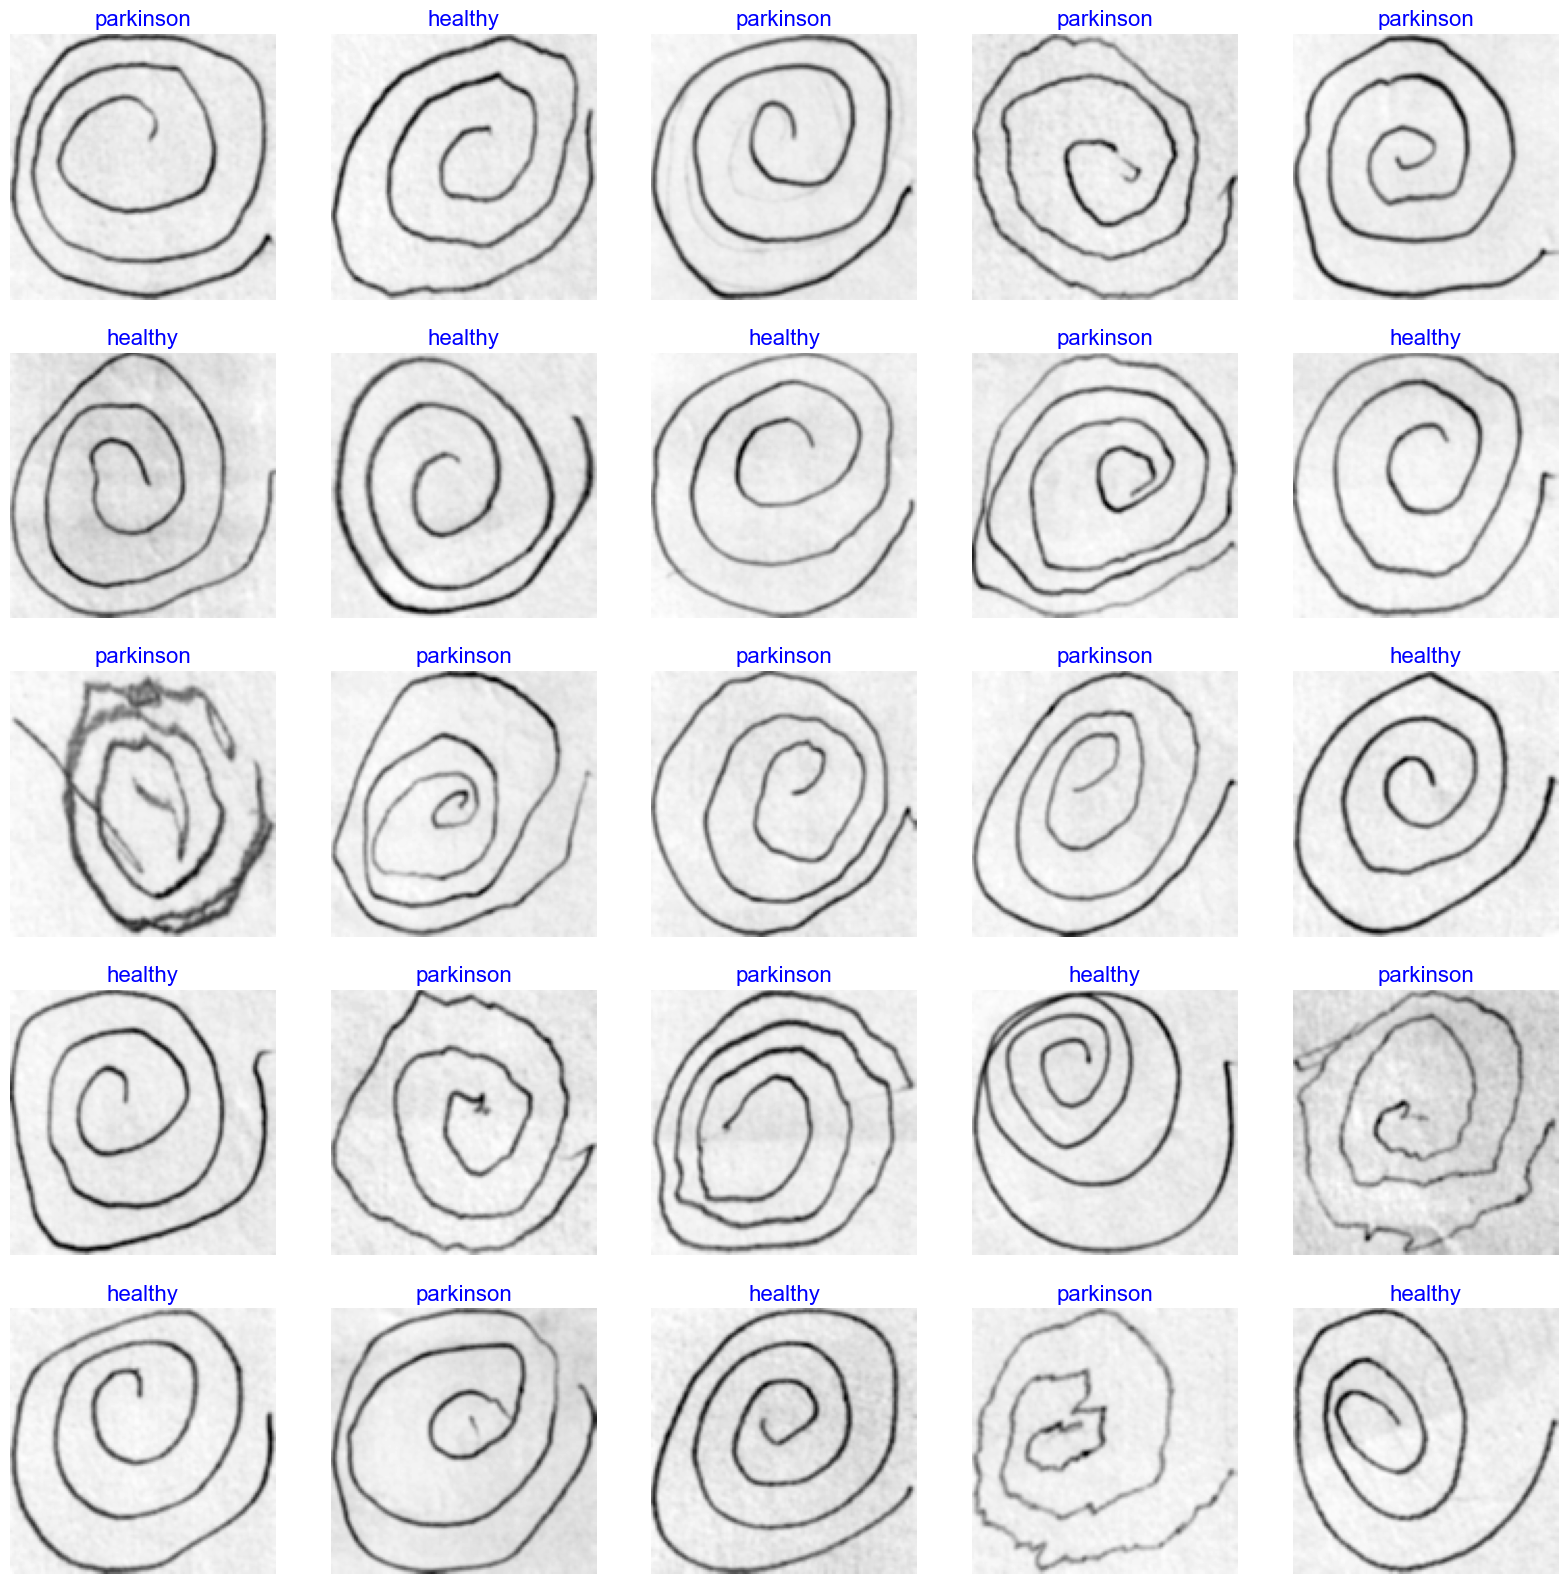

In [7]:
show_image_samples(train_gen)

### Create the model

In [8]:
base_model=tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(128,128,3)),
    classifier_activation="softmax",
)

In [9]:
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']   

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 32, 32, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 16, 16, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 16, 16, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 16, 16, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 16, 16, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 8, 8, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 8, 8, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 8, 8, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 8, 8, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 8, 8, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 8, 8, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 8, 8, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 8, 8, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 8, 8, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 8, 8, 1024)  4096        ['conv4_block24_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 8, 8, 1024)  0           ['conv4_block25_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_1_conv (Conv2D)  (None, 8, 8, 128)    131072      ['conv4_block25_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 8, 8, 128)    147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block33_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 8, 8, 1312)  0           ['conv4_block32_concat[0][0]',   
 ate)                                                             'conv4_block33_2_conv[0][0]']   
                                                                                                  
 conv4_block34_0_bn (BatchNorma  (None, 8, 8, 1312)  5248        ['conv4_block33_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 8, 8, 1440)  5760        ['conv4_block37_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 8, 8, 1440)  0           ['conv4_block38_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block38_1_conv (Conv2D)  (None, 8, 8, 128)    184320      ['conv4_block38_0_relu[0][0]']   
                                                                                                  
 conv4_block38_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block38_1_conv[0][0]']   
 lization)

 conv4_block42_1_conv (Conv2D)  (None, 8, 8, 128)    200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block42_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block42_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 8, 8, 1728)  0           ['conv4_block45_concat[0][0]',   
 ate)                                                             'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 8, 8, 1728)  6912        ['conv4_block46_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block47_0_relu (Activati  (None, 8, 8, 1728)  0           ['conv4_block47_0_bn[0][0]']     
 on)      

 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 4, 4, 960)   0           ['conv5_block1_concat[0][0]',    
 te)                                                              'conv5_block2_2_conv[0][0]']    
                                                                                                  
 conv5_block3_0_bn (BatchNormal  (None, 4, 4, 960)   3840        ['conv5_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block7_0_bn (BatchNormal  (None, 4, 4, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 4, 4, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, 4, 4, 128)    139264      ['conv5_block7_0_relu[0][0]']    
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block7_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block11_1_relu[0][0]']   
                                                                                                  
 conv5_block11_concat (Concaten  (None, 4, 4, 1248)  0           ['conv5_block10_concat[0][0]',   
 ate)     

 conv5_block15_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 4, 4, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_block16_0_bn (BatchNorma  (None, 4, 4, 1376)  5504        ['conv5_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_0_relu (Activati  (None, 4, 4, 1376)  0           ['conv5_block16_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block20_0_relu (Activati  (None, 4, 4, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 4, 4, 128)    192512      ['conv5_block20_0_relu[0][0]']   
                                                                                                  
 conv5_block20_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block20_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block24_1_relu[0][0]']   
                                                                                                  
 conv5_block24_concat (Concaten  (None, 4, 4, 1664)  0           ['conv5_block23_concat[0][0]',   
 ate)                                                             'conv5_block24_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block28_concat (Concaten  (None, 4, 4, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 4, 4, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block29_0_relu (Activati  (None, 4, 4, 1792)  0           ['conv5_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block29_1_conv (Conv2D)  (None, 4, 4, 128)    229376      ['conv5_block29_0_relu[0][0]']   
          

Total params: 18,321,984
Trainable params: 18,092,928
Non-trainable params: 229,056
__________________________________________________________________________________________________


In [10]:
base_model.trainable = False 

In [11]:
model_name = 'Cendekia'
print("Building model with", base_model)

# Membangun model Sequential
model = tf.keras.Sequential([
    # Lapisan pertama menggunakan base_model (model dasar yang telah didefinisikan sebelumnya)
    base_model,
    
    # Lapisan konvolusi pertama
    tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
    
    # Lapisan MaxPooling
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    # Lapisan dropout untuk mengurangi overfitting
    tf.keras.layers.Dropout(rate=0.5),
    
    # Mengubah output ke dalam bentuk vektor
    tf.keras.layers.Flatten(),
    
    # Lapisan Dense (fully connected) dengan 2 unit dan aktivasi softmax
    tf.keras.layers.Dense(2, activation='softmax')
])

# Mengkompilasi model dengan pengoptimal Adam, fungsi loss categorical_crossentropy, dan metrik akurasi
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


Building model with <keras.engine.functional.Functional object at 0x000002003B4D2A40>


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 32)          552992    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 32)          0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                        

In [13]:
epochs = 20
# Melatih model dengan data pelatihan (train_gen) selama sejumlah epochs yang ditentukan
# serta menggunakan data validasi (valid_gen) untuk validasi selama pelatihan.
history = model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/20
2/2 [==============================] - 23s 6s/step - loss: 1.3984 - accuracy: 0.4912 - val_loss: 0.5980 - val_accuracy: 0.7500
Epoch 2/20
2/2 [==============================] - 1s 972ms/step - loss: 0.9796 - accuracy: 0.5263 - val_loss: 0.5562 - val_accuracy: 0.7500
Epoch 3/20
2/2 [==============================] - 1s 830ms/step - loss: 0.7734 - accuracy: 0.5965 - val_loss: 0.6029 - val_accuracy: 0.5000
Epoch 4/20
2/2 [==============================] - 1s 704ms/step - loss: 0.5815 - accuracy: 0.8070 - val_loss: 0.4762 - val_accuracy: 0.7500
Epoch 5/20
2/2 [==============================] - 2s 827ms/step - loss: 0.4552 - accuracy: 0.7719 - val_loss: 0.5070 - val_accuracy: 0.7500
Epoch 6/20
2/2 [==============================] - 1s 923ms/step - loss: 0.7231 - accuracy: 0.7193 - val_loss: 0.4534 - val_accuracy: 0.7500
Epoch 7/20
2/2 [==============================] - 1s 555ms/step - loss: 0.5804 - accuracy: 0.7368 - val_loss: 0.4838 - val_accuracy: 0.7500
Epoch 8/20
2/2 [======

### Define function to print text in RGB foreground and background colors

In [14]:
def print_in_color(txt_msg, fore_tupple, back_tupple):
    # Mencetak teks dalam warna foreground yang ditentukan oleh fore_tupple dengan latar belakang yang ditentukan oleh back_tupple
    # txt_msg adalah teks, fore_tupple adalah tupel warna foreground (r, g, b), back_tupple adalah tupel latar belakang (r, g, b)
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' + str(gb) + ';' + str(bb) + 'm' 
    print(msg.format(mat), flush=True)
    print('\33[0m', flush=True)  # mengembalikan warna cetak default ke hitam
    return

### define function to plot the training data

In [15]:
def tr_plot(tr_data, start_epoch):
    # Mendapatkan data akurasi dan loss dari objek history pelatihan
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    
    # Menghitung jumlah epoch
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    
    # Mencari epoch dengan nilai loss validasi terendah
    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]
    
    # Mencari epoch dengan nilai akurasi validasi tertinggi
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    
    # Membuat plot dengan dua subplot (Loss dan Akurasi)
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    # Plot Loss
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Plot Akurasi
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()
    
    # Menampilkan plot
    plt.show()


### Define function to generate the confusion matrix and classification report

In [16]:
def print_info(test_gen, preds, print_code, save_dir, subject):
    # Mendapatkan kamus (dictionary) indeks kelas dari generator pengujian
    class_dict = test_gen.class_indices
    
    # Mendapatkan label dari data pengujian
    labels = test_gen.labels
    
    # Mendapatkan nama file dari data pengujian
    file_names = test_gen.filenames
    
    # Daftar yang akan menyimpan informasi kesalahan prediksi
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []
    
    # Membentuk kamus yang mengaitkan indeks dengan nama kelas
    for key, value in class_dict.items():
        new_dict[value] = key
    
    # Simpan kamus baru sebagai file teks di direktori penyimpanan (save_dir)
    classes = list(new_dict.values())
    dict_as_text = str(new_dict)
    dict_name = subject + '-' + str(len(classes)) + '.txt'
    dict_path = os.path.join(save_dir, dict_name)
    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    
    errors = 0
    
    # Loop melalui hasil prediksi dan label sebenarnya untuk mengecek kesalahan prediksi
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]
        
        if pred_index != true_index:  # Terjadi kesalahan klasifikasi
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors = errors + 1
        
        y_pred.append(pred_index)
    
    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code
            
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class', 'True Class', 'Probability')
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + '/' + split1[1]
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i], true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255, 255, 255), (55, 65, 60))
        else:
            msg = 'With accuracy of 100% there are no errors to print'
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
    
    if errors > 0:
        # Plot jumlah kesalahan per kelas
        plot_bar = []
        plot_class = []
        
        for key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count)
                plot_class.append(value)
        
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x)
        
        plt.title('Errors by Class on Test Set')
    
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    
    if len(classes) <= 30:
        # Membuat confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * 0.5)
            fig_height = int(length * 0.5)
        
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + 0.5, classes, rotation=90)
        plt.yticks(np.arange(length) + 0.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
    
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)


### evaluate model on the test set then save the model

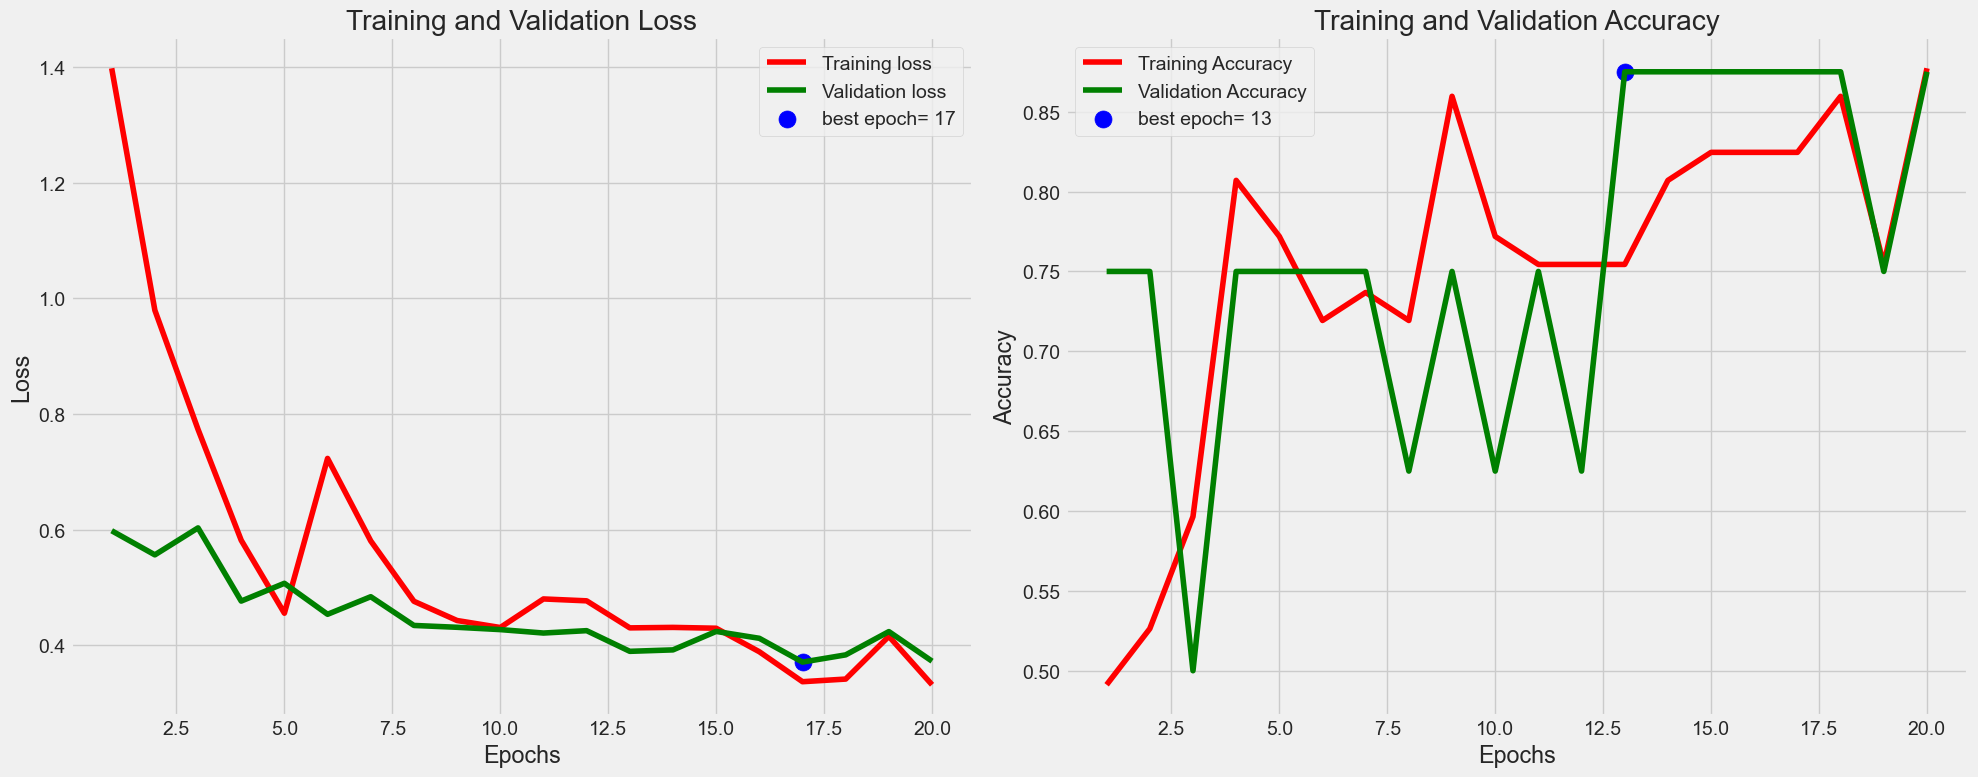

1/1 [==============================] - 0s 256ms/step - loss: 0.5363 - accuracy: 0.7143
accuracy on the test set is 71.43 %



In [17]:
# Memplot grafik pelatihan dengan fungsi tr_plot
tr_plot(history, 0)

# Direktori tempat Anda akan menyimpan file
save_dir = r'./'

# Nama subjek (subject) yang digunakan
subject = 'pest'

# Menghitung akurasi model pada data pengujian
acc = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1] * 100

# Membuat pesan tentang akurasi pengujian
msg = f'accuracy on the test set is {acc:5.2f} %'

# Mencetak pesan dengan warna tertentu menggunakan fungsi print_in_color
print_in_color(msg, (0, 255, 0), (55, 65, 80))

# Menyusun nama file penyimpanan model
save_id = str(model_name + '-' + subject + '-' + str(acc)[:str(acc).rfind('.') + 3] + '.h5')
save_loc = os.path.join(save_dir, save_id)

# Menyimpan model ke lokasi yang ditentukan
model.save(save_loc)


### make predictions on test set and generate confusion matrix and classification report

1/1 [==============================] - 5s 5s/step
Classification Report:
----------------------
               precision    recall  f1-score   support

     healthy       0.33      1.00      0.50         1
   parkinson       1.00      0.67      0.80         6

    accuracy                           0.71         7
   macro avg       0.67      0.83      0.65         7
weighted avg       0.90      0.71      0.76         7



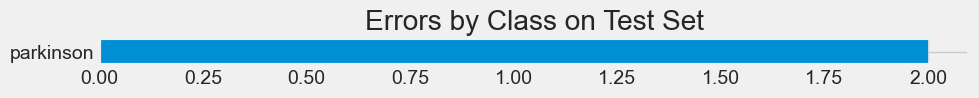

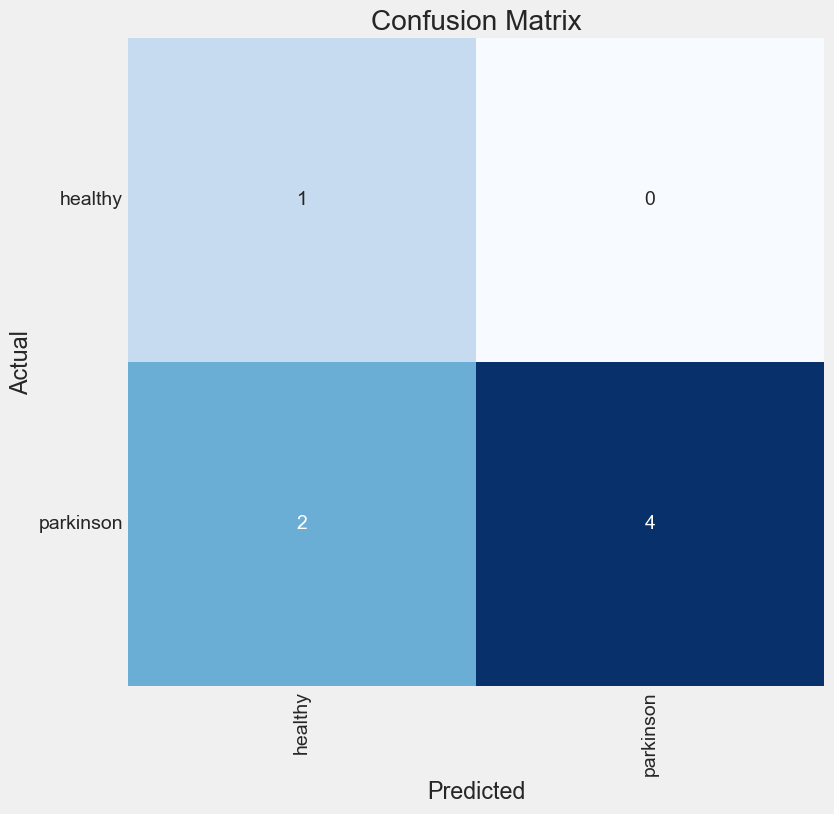

In [18]:
print_code = 0

# Melakukan prediksi menggunakan model terhadap data pengujian
preds = model.predict(test_gen)

# Memanggil fungsi print_info untuk mencetak informasi performa model
print_info(test_gen, preds, print_code, save_dir, subject)
